## Monte Carlo Methods to Estimate and Optimize PageRank
#### EN.553.433 Monte Carlo Methods: Final Project
#### Viggy Vanchinathan, May 2025

__Abstract__: PageRank is arguably the single most important algorithm of the modern Information age, generating billions in revenue for Google and changing the way we interacted with the Internet forever. Despite it's reach, the algorithm is remarkably simple, essentially modeling the millions of pages on the World Wide Web as a Markov Chain, and ranking pages based on their normalized probability in it's stationary distribution. Here, we demonstrate the use of Monte Carlo methods to estimate PageRank on a few examples, with a few extension points for optimization of the algorithm. 

__Introduction__

PageRank was introduced in the seminal 1998 whitepaper: *The PageRank Citation Ranking: Bringing Order to the Web*. In the 90s, the number of webpages on the World Wide Web was growing exponentially doubling every year, leading to an increased demand for an intuitive, accurate, and fast way to search for relevant content. There were manual indexes of sites maintained (such as Yahoo), but, because they were manual, were cumbersome and slow to update. Search engines were tools build to query the wealth of pages being indexed. Many (such as Altavista) existed, but often failed to return results that matched the search query. 

Lawrence Page, Sergey Brin, Rajeev Motwani, and Terry Winograd, Computer Science PhDs, introduced a new and improved search engine, Google, alongside a new algorithm they used to rank the importance of webpages effectively, PageRank. This algorithm alone won them a competitive spot in the "Browser War" of the early 2000s, catapulting them to fame. Today, Alphabet, the parent holding company of Google, is worth approximately $1.84 trillion dollars.


### Suboptimal Centrality Measures
How do we measure page importance?

The setup:

Let the internet be a directed graph $G=(V, E)$, with each independent webpage as a node in $V$, and hyperlinks from one page to another as a directed edge in $E$ between the nodes. Links leaving a page are "outedges", and links arriving at a page are "inedges". We need a way to measure the importance of a webpage, so that it can come up near the top of a search query. 

One intuitive option is to use **Degree Centrality** as a measure of importance. The importance of a node v is: $$I(v) = deg(v)$$

Intuitively, the number of other nodes connected to v.

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import networkx as nx

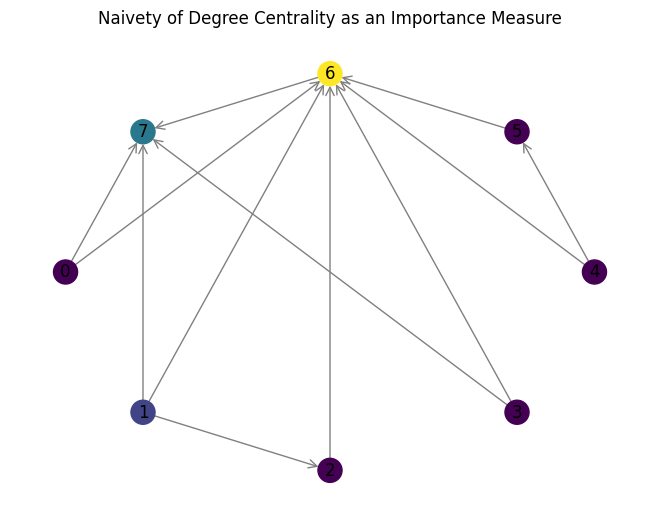

In [27]:
#demonstrating the flaws with counting edges (Degree Centrality)

adj_matrix_naive = np.array([
    [0, 0, 0, 0, 0, 0, 1, 1],
    [0, 0, 1, 0, 0, 0, 1, 1],
    [0, 0, 0, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 1, 1],
    [0, 0, 0, 0, 0, 1, 1, 0],
    [0, 0, 0, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 1],
    [0, 0, 0, 0, 0, 0, 0, 0]
])

graph_naive = nx.from_numpy_array(adj_matrix_naive, create_using=nx.DiGraph)
dc = nx.degree_centrality(graph_naive)

# 4. Draw the graph
pos = nx.shell_layout(graph_naive)
nx.draw(graph_naive, pos, with_labels=True,
        node_color= list(dc.values()),
        edge_color='gray',
        arrows=True,
        arrowstyle='->',
        arrowsize=15)

plt.title("Naivety of Degree Centrality as an Importance Measure")
plt.show()

Notice that page 6 and 7 have the highest importance in this graph, but that there is no way to weight the importance a single edge. An inedge from many reputable sources should contribute more to the centrality measure than the same number of inedges from dubious sources. 

Additionally, actors interested in boosting visibility to their site may attempt to game the metric by artificially increasing inedges to their site by generating fake pages. We need a new measure that weights incoming edges by the importance of the departure node.

One way to combat this is to use another measure of importance, one that depends more on the importance of the nodes that connect to it. One such measure is **eigenvector centrality**, which is defined as a vector $x$ such that:
$$x_v = \frac{1}{\lambda} \sum_{t \in V} a_{vt} x_t$$

which boils down to the regular eigenvector equation:

$$Ax = \lambda x$$

Intuitively, the vector of centrality measures for each node is just the corresponding term in the eigenvector with the highest eigenvalue.


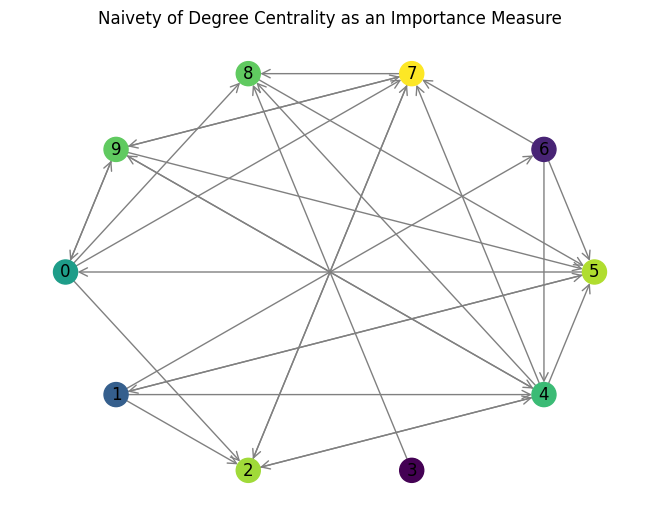

In [82]:
#demonstration of eigenvector centrality

graph_ev = nx.gnp_random_graph(n=10, p=0.3, directed=True, seed=101)
ev = nx.eigenvector_centrality(graph_ev)

# 4. Draw the graph
pos = nx.shell_layout(graph_ev)
nx.draw(graph_ev, pos, with_labels=True,
        node_color= list(ev.values()),
        edge_color='gray',
        arrows=True,
        arrowstyle='->',
        arrowsize=15)

plt.title("Naivety of Degree Centrality as an Importance Measure")
plt.show()

This does a better job of assigning importance to nodes that are connected to other important ones. Page 3 is of very low importance, because it does not connect to any more high-profile pages besides 8, and has no "hyperlinks"/edges to it. Not also the difference between Pages 6 and 1, which have the same degree. However, 1 is pointed to by 5, and 6 is pointed to by only 1. 5 is more important than 1, so it makes sense that Page 1 is more important than Page 6.

How can we calculate the rank of a node if we need to know the rank of another node first? #TODO add power iteration visual to calculate eigenvalue  

We define a simplified version of PageRank based on eigenvalue centrality. It's essentially the same thing. The ranking $R$ is:
$$ R(u) = c \sum_{v \in B_u} \frac{R(v)}{N_v} $$

Where $B_u$ is the set of backlinks to node $u$ (i.e. all the pages that point to $u$), $N_v$ is the number of edges out of node $v$, $R(v)$ is the ranking of node $v$, and $c$ is a normalization factor so that the sum of all ranks is 1. Intuitively, the ranking of a node is the sum of the weighted contributions from the nodes that connect to it. More important nodes mean a higher rank. Also note that this is a recursive/circular definition.

### Markovian Properties of WWW

We understand that because we travel from one site to the next based on page links, a random walk along this graph is **Markovian**. We also may have multiple links from one site to another, introducing weighted edges into our graphs. We can attempt to find the **stationary distribution** of the markov chain by repeatedly applying the transition matrix to the matrix of ranks. The transition matrix will need to be normalized to the columns, because we make the rank determination on the incoming links, not outgoing links.

TODO add formal algorithm here?

In [71]:
N = 100
n = 10  #number of nodes
max_iters = N

eps = 1e-6 #threshold to mark convergence

In [72]:
#perform single update of ranks
def update(ranks, g):
        adj = nx.to_numpy_array(g)
        assert len(ranks) == len(adj), "Distribution length must match number of nodes"  
        norm_adj = adj / adj.sum(axis=1, keepdims=True)
        
        return ranks @ norm_adj

#return total variational distance
def tvd(prev_rank, curr_rank):
        assert len(prev_rank) == len(curr_rank), "rank vectors must be same length"
        return 0.5 * np.sum(np.abs(curr_rank - prev_rank))


Text(0.5, 1.0, 'Total Variational Distance between Rank Vectors')

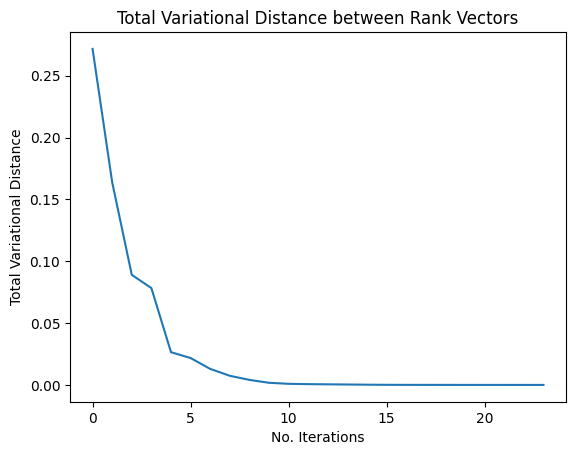

In [80]:
rank = np.full(n, 1/n)
no_it = 0
tvds = []
tvd_it = eps + 1 #init above eps to enter loop

#test convergence for connected example.
while tvd_it > eps and no_it < 100:
    new_rank = update(rank, graph_ev)
    tvd_it = tvd(prev_rank=rank, curr_rank=new_rank)
    tvds.append(tvd_it) #keep track of tvds for plotting
    rank = new_rank
    no_it += 1
    
plt.plot(np.arange(0, len(tvds), 1), np.array(tvds))
plt.xlabel("No. Iterations")
plt.ylabel("Total Variational Distance")
plt.title("Total Variational Distance between Rank Vectors")

Now that we have a converged rank vector, let's compare it to the earlier eigenvector similarity metric. We should get similar values...

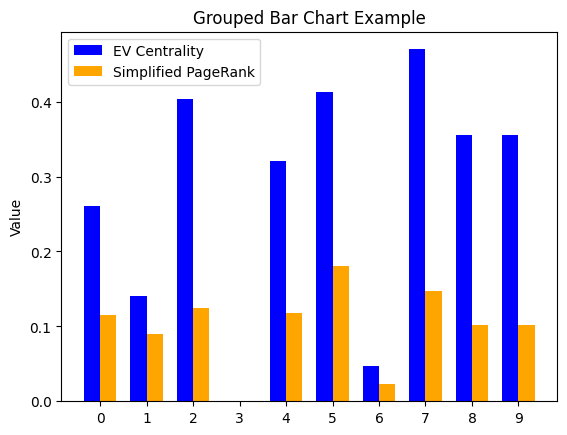

In [93]:
x = np.arange(n)
width = 0.35

plt.bar(x - width/2, ev.values(), width, label='EV Centrality', color='blue')
plt.bar(x + width/2, rank, width, label='Simplified PageRank', color='orange')

# Labeling
plt.xticks(x)
plt.ylabel('Value')
plt.title('Grouped Bar Chart Example')
plt.legend()

number of nodes:  16
number of edges:  16

Adjacency Matrix: 

[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]

eigenvalues, ascending order:

1.3877787807814457e-17
0.0761204674887132
0.29289321881345265
0.61731656763491
1.0000000

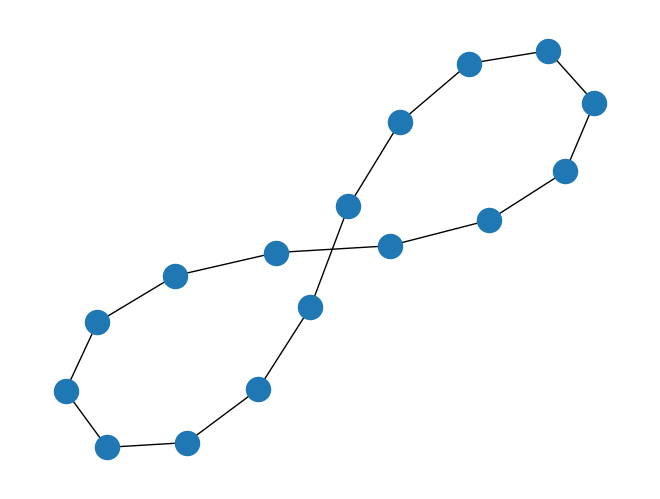

In [43]:
# Test the networkx library
graph = nx.cycle_graph(16)
nx.draw(graph)
plt.show

print("number of nodes: ", graph.number_of_nodes())
print("number of edges: ", graph.number_of_edges())
print("\nAdjacency Matrix: \n")
print(nx.to_numpy_array(graph)) #print graph in matrix form, not sparse form for now

#find eigencvalues of normalized laplacian  
nlm = nx.normalized_laplacian_matrix(graph).todense()
lambdas = np.linalg.eigvals(nlm)

print("\neigenvalues, ascending order:\n")
for i in lambdas:
    print(i)




In [14]:
class GraphMC(nx.Graph):
    def __init__(self, graph):
        super().__init__(graph)  # Initialize from an existing graph
    
    def transition_probabilities(self, start_node, end_node):
        assert start_node in self.nodes, "Start node must be in the graph"
        assert end_node in self.nodes, "End node must be in the graph"
        adj = nx.to_numpy_array(graph)
        return adj[start_node][end_node]

    def stationary_distribution(self, node):
        assert node in self.nodes, "Node must be in the graph"
        deg = self.degree(node)
        
        return deg/(2*self.number_of_edges()) #because cycle graph is ergodic

    def update(self, distribution, num_steps=1):
        assert len(distribution) == len(self.nodes), "Distribution length must match number of nodes"
        degrees = np.array([degree for node, degree in self.degree()])
        adj = nx.to_numpy_array(graph) / degrees
        #print(adj)
        distribution = np.array(distribution)
        for _ in range(num_steps):
            distribution = distribution @ adj
            #print(distribution)
        
        return distribution

    def total_variational_distance(self, distribution):
        assert len(distribution) == len(self.nodes), "Distribution length must match number of nodes"
        
        #generate stationary distrbution
        stat_dist = []
        for node in self.nodes:
            stat_dist.append(self.stationary_distribution(node))
        
        stat = np.array(stat_dist)
        
        return 0.5 * np.sum(np.abs(np.array(distribution) - stat))

    def mixing_time(self, starting_distribution, epsilon=0.25, max_steps=1000):
        assert len(starting_distribution) == len(self.nodes), "Distribution length must match number of nodes"
        counter = 0
        
        good = 0
        dist = starting_distribution
        for i in range(max_steps):
            tvd = self.total_variational_distance(dist)
            if tvd < epsilon:
                good = 1
                break
            counter += 1
            dist =  self.update(dist)
            
        if good == 0:
            raise ValueError
        
        return counter 
                


mixing time:  43


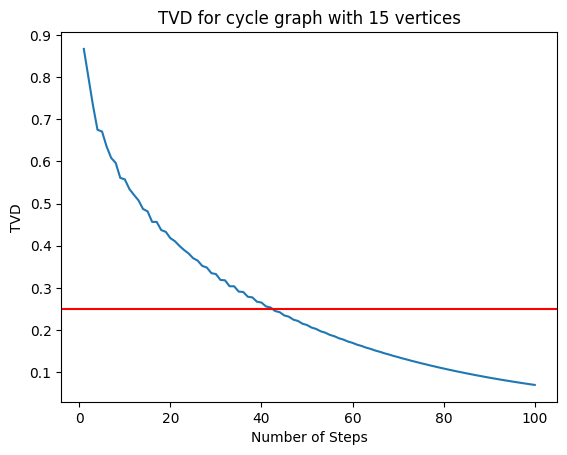

In [4]:
# Test 1

graph = nx.cycle_graph(15)
g = GraphMC(graph)

starting_dist = [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
dist = starting_dist
tvd = []
for i in range(100):
    dist = g.update(dist)
    tvd.append(g.total_variational_distance(dist))

plt.plot(np.linspace(1,100,100), tvd)
plt.xlabel("Number of Steps")
plt.ylabel("TVD")
plt.title("TVD for cycle graph with 15 vertices")
plt.axhline(0.25, c='r')

print("mixing time: ", g.mixing_time(starting_distribution=starting_dist))

ValueError: 

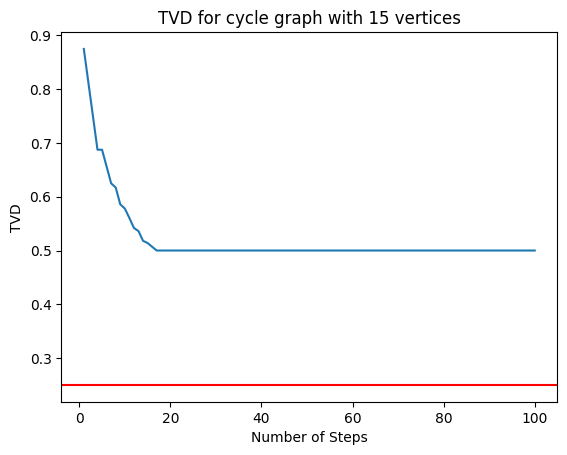

In [5]:
# Test 2

graph = nx.cycle_graph(16)
g = GraphMC(graph)

starting_dist = [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
dist = starting_dist
tvd = []
for i in range(100):
    dist = g.update(dist)
    tvd.append(g.total_variational_distance(dist))

plt.plot(np.linspace(1,100,100), tvd)
plt.xlabel("Number of Steps")
plt.ylabel("TVD")
plt.title("TVD for cycle graph with 15 vertices")
plt.axhline(0.25, c='r')

print("mixing time: ", g.mixing_time(starting_distribution=starting_dist))

In [6]:
# Mixing time as a function of cycle length and spectral gap

mix = []
for i in range(3, 52):
    start = np.zeros(i)
    start[0] = 1
    g = GraphMC(nx.cycle_graph(i))
    mix.append(g.mixing_time(start))

print(mix)

ValueError: operands could not be broadcast together with shapes (16,16) (3,) 

#### References
1. [The PageRank Citation Ranking: Bringing Order to the Web](https://www.cis.upenn.edu/~mkearns/teaching/NetworkedLife/pagerank.pdf) (original technical whitepaper written by Lawrence Page, Sergey Brin, Rajeev Motwani, and Terry Winograd)
2. [The Anatomy of a Large-Scale Hypertextual Web Search Engine](https://snap.stanford.edu/class/cs224w-readings/Brin98Anatomy.pdf) (paper introducing Google Search Engine itself)
3. [How we got from 1 to 162 million websites on the Internet](https://www.pingdom.com/blog/how-we-got-from-1-to-162-million-websites-on-the-internet/)
4. [Browser Wars (Wikipedia)](https://en.wikipedia.org/wiki/Browser_wars)
5. [Centrality Measures (Wikipedia)](https://en.wikipedia.org/wiki/Centrality)
6. [Perron-Frobenius Theorem (Wikipedia)](https://en.wikipedia.org/wiki/Perron%E2%80%93Frobenius_theorem)

I also watched a few YouTube videos to make sure my intuitive understanding lined up with the more formal setup:

[x] [How Google's PageRank Algorithm Works](https://youtu.be/meonLcN7LD4?si=K8h-H7--f47u5bOB)
